In [14]:
# Student - Tim Tieng
# Program - MS in Applied Data Science
# Course - IST-718 Big Data Analytics
# Instructor - Professor Jill Lando

#Attestation
# I used the course materials and the following resources to complete this assignment:
# 1. https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file 
# 2. I used the video from asyncrhonous to make the load_data() function
# 3. https://www.tensorflow.org/ 

In [15]:
# Import Packages
import os
import struct
import pandas as pd  # data frame operations
from pandas.plotting import scatter_matrix  # scatter plot matrix
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Used for Time Series Analysis
#import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
#from statsmodels.tsa.stattools import acf, pacf # used for TSA
#from statsmodels.tsa.arima.model import ARIMA # used to conduct AutoRegressive Integrated Moving Average Modeling
#from statsmodels.tsa.stattools import adfuller # used to conduct ADF test for stationary/non-stationary data for TSA
from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method
from sklearn.model_selection import train_test_split, cross_val_score # Used of ML tasks
# from sklearn.metrics import mean_squared_error # Used to calculate MSE, essential in regression modeling
import matplotlib.pyplot as plt # Visualizations
from matplotlib.ticker import FuncFormatter # Formatting Visualizations
import matplotlib.dates as mdates # Visualization package to work with date and time data
import seaborn as sns # Another Visualization package; formatting/aesthetics
import statsmodels.api as sm # Statistical Modeling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
# from datetime import datetime
# from data_cleaning_general import standardize_text_casing, convert_datatypes, remove_null_values, replace_null_with_mean, replace_null_with_median
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

In [16]:
# Obtain the Data - Read in provided data

def load_mnist_data(path,kind='train'):
    labels_path = os.path.join(path,
                                '%s-labels-idx1-ubyte'
                              % kind)
    images_path = os.path.join(path,
                              '%s-images-idx3-ubyte'
                              % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open (images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

In [17]:
X_train, y_train = load_mnist_data('/Users/timtieng/Library/CloudStorage/OneDrive-Personal/Desktop/Masters in Applied Data Science/IST-718 Big Data Analytics/Labs/Lab 3/Data', kind='train')

In [18]:
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [19]:
X_test, Y_test = load_mnist_data('/Users/timtieng/Library/CloudStorage/OneDrive-Personal/Desktop/Masters in Applied Data Science/IST-718 Big Data Analytics/Labs/Lab 3/Data', kind='t10k')

In [20]:
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


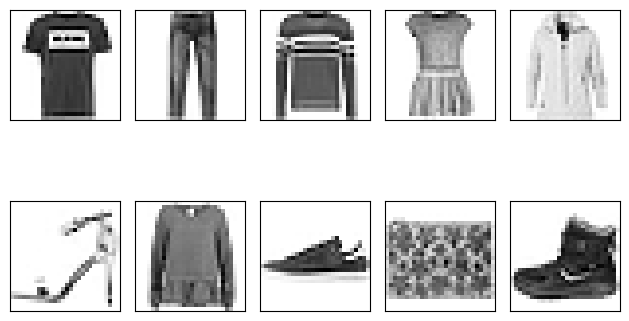

In [21]:
# Visualize all of the classes/labels - Types of clothing
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

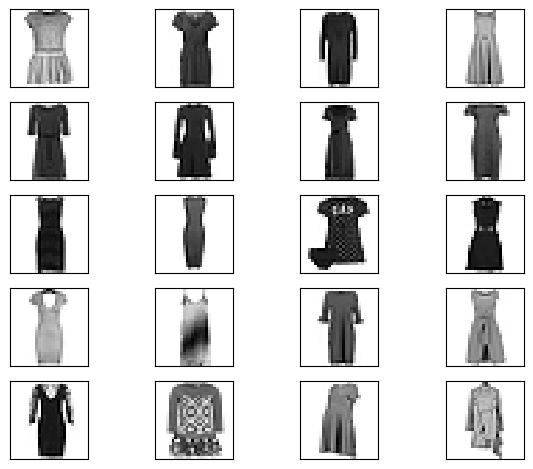

In [22]:
# Visualize different versions of a given class/label

fig, ax = plt.subplots(nrows=5, ncols=4, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(20):
    img = X_train[y_train == 3][i].reshape(28, 28) # change the y_train value to see different types of labels
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [23]:
# Read in the csv files
mnist_train_filepath = "/Users/timtieng/Library/CloudStorage/OneDrive-Personal/Desktop/Masters in Applied Data Science/IST-718 Big Data Analytics/Labs/Lab 3/Data/fashion-mnist_train.csv"
mnist_test_filepath = "/Users/timtieng/Library/CloudStorage/OneDrive-Personal/Desktop/Masters in Applied Data Science/IST-718 Big Data Analytics/Labs/Lab 3/Data/fashion-mnist_test.csv"

mnist_train = pd.read_csv(mnist_train_filepath)
mnist_test = pd.read_csv(mnist_test_filepath)

mnist_train.head()

mnist_test.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9999,1,0,0,0,0,0,0,0,140,119,...,111,95,75,44,1,0,0,0,0,0


In [24]:
# Classification Approach 1- Naive Bayes

# Separate the features and the labels
X_train = mnist_train.drop('label', axis=1)
y_train = mnist_train['label']
X_test = mnist_test.drop('label', axis=1)
y_test = mnist_test['label']

# Scaling the data to [0,1] because Naive Bayes prefers data to be in the same scale
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the data
nb_classifier.fit(X_train_scaled, y_train)

# Predict the labels of the test set
y_pred = nb_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy: 66.75%
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1000
           1       0.97      0.90      0.94      1000
           2       0.63      0.61      0.62      1000
           3       0.66      0.90      0.76      1000
           4       0.47      0.62      0.53      1000
           5       0.71      0.16      0.27      1000
           6       0.33      0.15      0.20      1000
           7       0.59      0.90      0.71      1000
           8       0.89      0.84      0.86      1000
           9       0.69      0.82      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.64     10000
weighted avg       0.67      0.67      0.64     10000



In [25]:
# Approach 2 - Neural networks
# Separate the features and the labels and convert to numpy arrays
X_train = mnist_train.drop('label', axis=1).values
y_train = mnist_train['label'].values
X_test = mnist_test.drop('label', axis=1).values
y_test = mnist_test['label'].values

# encode the labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Normalize the image data to 0-1
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Create a Sequential model
model = Sequential()

# Flatten the input data
model.add(Flatten(input_shape=(784,)))

# Add a Dense layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

# Add a Dense layer with the number of classes and softmax activation
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_normalized, y_train_encoded, epochs=10)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=0)

print(f"Neural Network Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10


/Users/timtieng/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - accuracy: 0.7752 - loss: 0.6390
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.8606 - loss: 0.3878
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.8749 - loss: 0.3445
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.8836 - loss: 0.3146
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8896 - loss: 0.2997
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.8970 - loss: 0.2818
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.9022 - loss: 0.2699
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.9041 - loss: 0.2590
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.9068 - loss: 0.2505
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.9118 - loss: 0.2398
Neural Network Test accuracy: 89.43%
